# Part 1: Data
Create synthetic multi-variate Gaussian data using parameters I chose

In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [201]:
m = 1
n = 500
d = 1
w = [1, 3]
μ = [-9, 4]
σ = [1, 2]


In [202]:
def generate_mixture_of_gaussians(n_samples, means, stds, weights):
    n_components = len(means)
    assert len(stds) == n_components and len(weights) == n_components
    data = []
    for _ in range(n_samples):
        component = np.random.choice(n_components, p=weights)
        sample = np.random.normal(means[component], stds[component])
        data.append([sample])
    return torch.tensor(data)

In [203]:
data = generate_mixture_of_gaussians(n, μ, σ, w/np.sum(w))

In [204]:
data[:10]

tensor([[-9.6112],
        [ 3.5674],
        [ 3.8962],
        [ 3.1411],
        [ 4.9637],
        [ 2.3971],
        [ 1.7773],
        [-9.8356],
        [-8.6423],
        [-8.8735]])

In [6]:
print(data[:10])
print(data.shape)

tensor([[ 7.0433],
        [ 3.3291],
        [ 2.8724],
        [-8.3893],
        [ 3.6640],
        [ 3.5034],
        [ 3.6533],
        [ 1.1592],
        [ 3.3869],
        [ 7.9923]])
torch.Size([500, 1])


In [205]:
train_dataloader = DataLoader(data, batch_size=32, shuffle=True)

(array([ 4., 37., 46., 34.,  9.,  0.,  0.,  0.,  0.,  1.,  5., 18., 45.,
        67., 81., 66., 48., 28.,  8.,  3.]),
 array([-11.71552181, -10.64742947,  -9.57933807,  -8.51124573,
         -7.44315386,  -6.37506199,  -5.30696964,  -4.23887777,
         -3.17078567,  -2.1026938 ,  -1.03460169,   0.03349032,
          1.10158229,   2.1696744 ,   3.23776627,   4.30585861,
          5.37395048,   6.44204235,   7.51013422,   8.57822609,
          9.64631844]),
 <BarContainer object of 20 artists>)

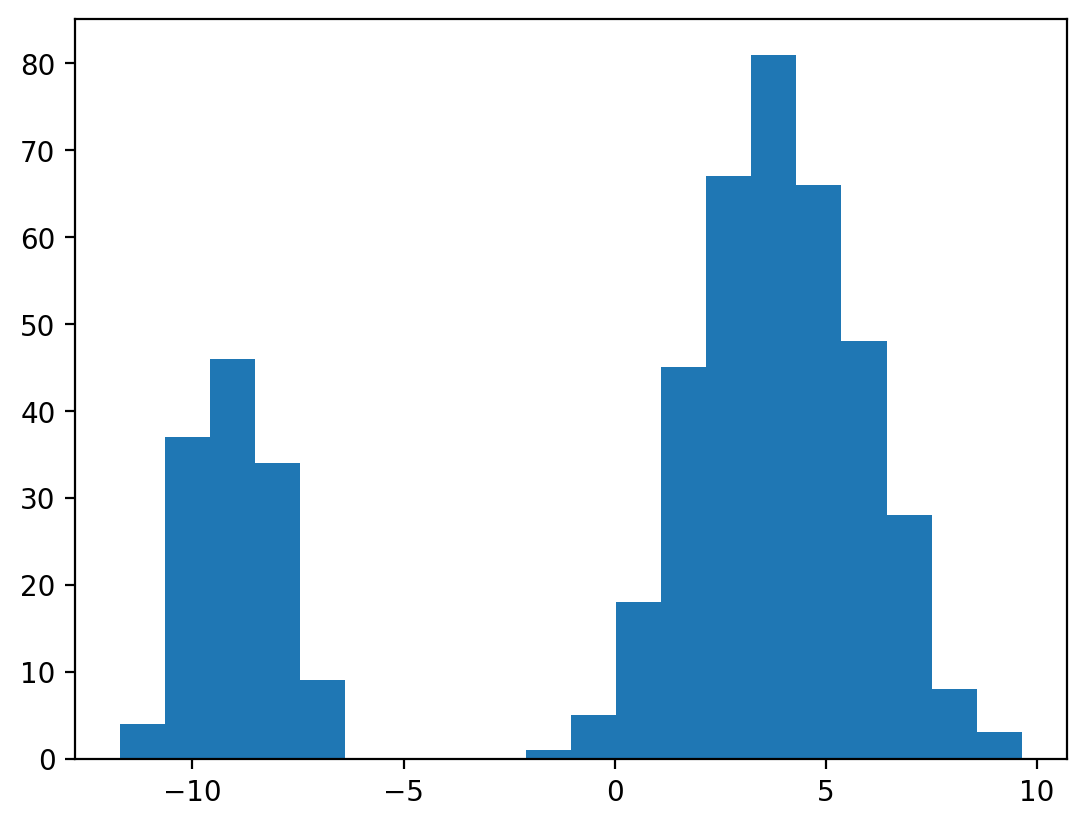

In [206]:
plt.hist(data.squeeze(1), bins=20)

# Part 2: Models

## Part 2.1: VAE

In [ ]:
%pip install torchvision

In [199]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [200]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(1, 20)
        self.linear2 = nn.Linear(20, latent_dims)
        self.linear3 = nn.Linear(20, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [58]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 20)
        self.linear2 = nn.Linear(20, 1)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = self.linear2(z)
        return z

In [59]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [64]:
def train(autoencoder, data, epochs=1000):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [67]:
latent_dims = 10

autoencoder = train(VariationalAutoencoder(latent_dims), train_dataloader)

(array([  1.,   1.,   0.,   0.,   5.,   5.,   6.,   8.,   9.,  19.,  29.,
         27.,  32.,  59.,  38.,  53.,  59.,  42., 119., 198., 155.,  81.,
         41.,   7.,   6.]),
 array([-33.11784744, -31.21938133, -29.32091331, -27.4224472 ,
        -25.52398109, -23.62551498, -21.72704697, -19.82858086,
        -17.93011475, -16.03164673, -14.13318062, -12.23471451,
        -10.33624744,  -8.43778133,  -6.53931427,  -4.64084768,
         -2.7423811 ,  -0.84391451,   1.0545522 ,   2.9530189 ,
          4.85148525,   6.74995232,   8.64841843,  10.54688549,
         12.4453516 ,  14.34381866]),
 <BarContainer object of 25 artists>)

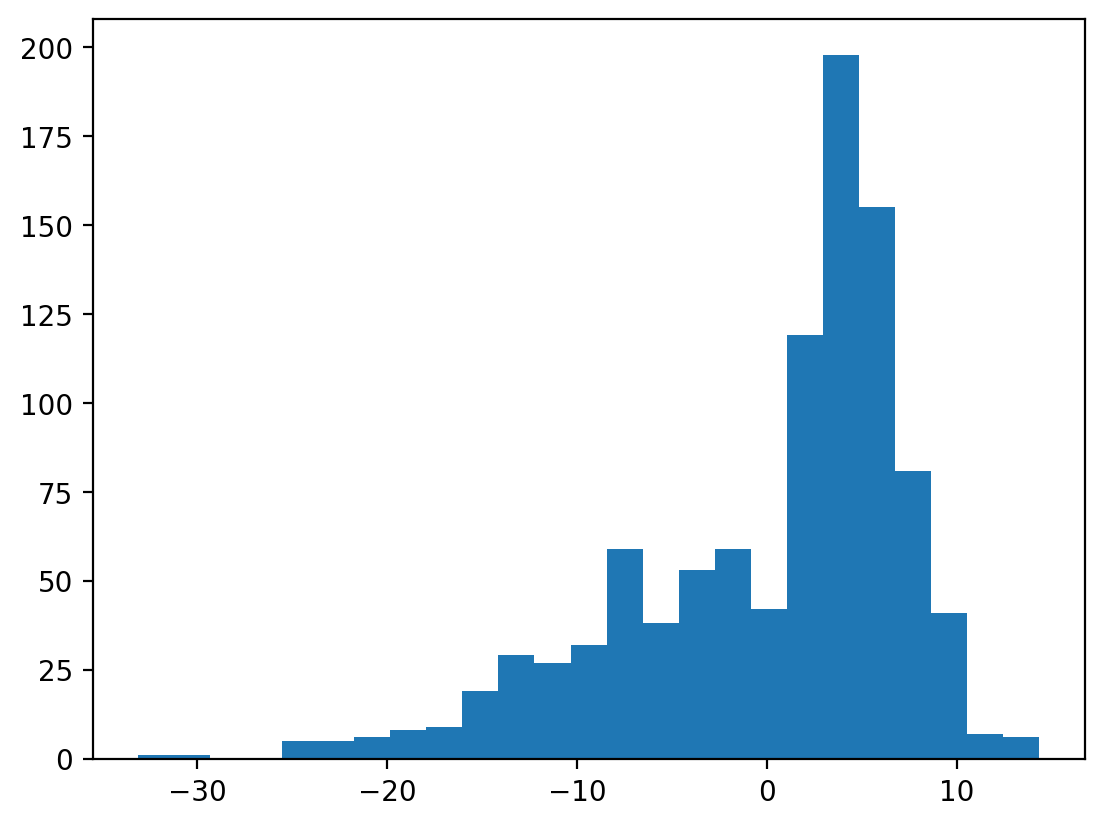

In [69]:
N = torch.distributions.Normal(0, 1)
X = []
for _ in range(1000):
    z = N.sample([latent_dims])
    x = autoencoder.decoder(z).detach().cpu().numpy()
    # print(x)
    X.append(x[0])
    
plt.hist(X, bins=25)

## Part 2.2: Score Matching
Match scores with a NN with loss
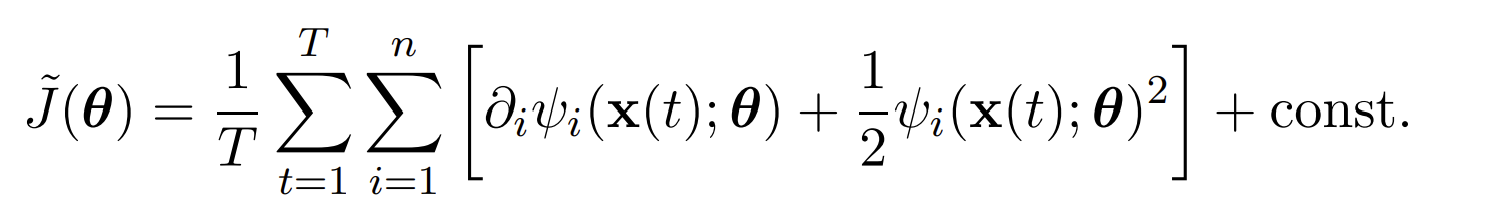 
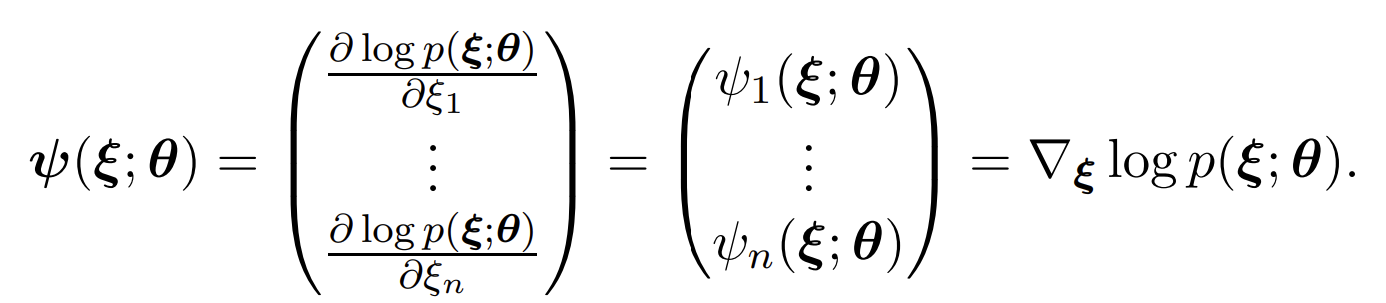

### Part 2.21: Model

In [207]:
def score_matching_loss(model, X):
    loss = None
    for x in X:
        x.requires_grad_(True)
        ψ = model(x)
        ψ.requires_grad_(True)
        dψ = torch.autograd.grad(ψ, x, create_graph=True)[0][0]
        ψ.requires_grad_(True)
        if loss is None:
            loss = dψ + .5 * ψ * ψ
        else:
            loss += dψ + .5 * ψ * ψ
    return loss

In [209]:
d=1

In [211]:
class ScoreMatcher(nn.Module):
    def __init__(self):
        super(ScoreMatcher, self).__init__()
        hidden_layers = [nn.Linear(10, 10), nn.ReLU()]*1
        self.net = nn.Sequential(
            nn.Linear(d, 10),
            *hidden_layers,
            nn.Linear(10, d),
        )

    def forward(self, x):
        return self.net(x)

model = ScoreMatcher()
optimizer = optim.Adam(model.parameters(), lr=.001)

num_epochs = 100

opt = (2000, None)
for epoch in range(num_epochs):
    avg_loss = 0
    for X in train_dataloader:
        output = model(X)
        loss = score_matching_loss(model, X)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss /= len(train_dataloader)
    opt = min(opt, (avg_loss, model))
model_opt = opt[1]

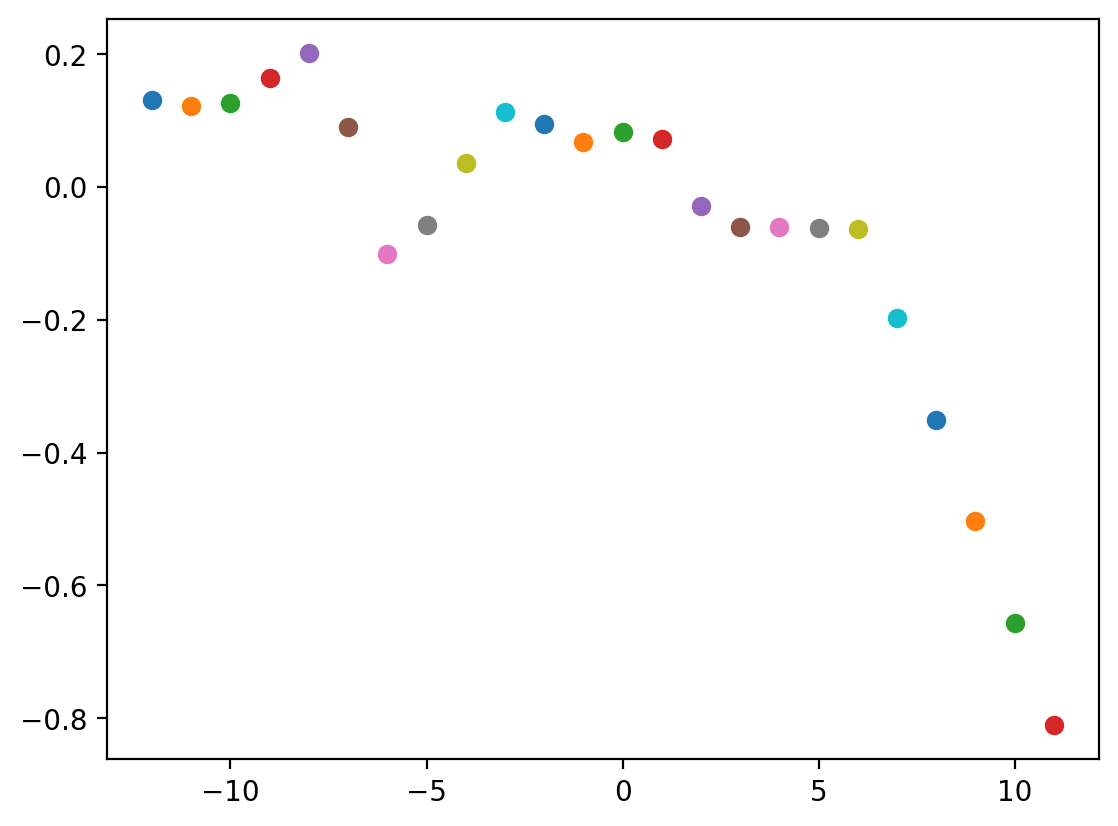

In [74]:
for v in range(-12, 12, 1):
    # print(v, float(model(torch.tensor([float(v)]))))
    plt.scatter(v, float(model_opt(torch.tensor([float(v)]))))
plt.show()

### Part 2.22: Sample

In [217]:
step_size = 0.1
num_steps = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [218]:
def sample_langevin_dynamics(model, n):
    X = torch.randn(n, d)
    for _ in range(num_steps):
        X.requires_grad_(True)
        ψ = model(X)
        X = X + step_size  * ψ + torch.distributions.Normal(0, 1).sample([n, d]) * sqrt(2 * step_size)
        X = X.detach()
    return X

In [ ]:
def annealed_langevin_dynamics(model, n, n_steps=10, step_size=0.1):
    X = torch.randn(n, d)
    alpha = 0.1
    for i in range(n_steps):
        X.requires_grad_(True)
        ψ = model(X)
        X = X + (step_size / (i + 1)) * ψ + torch.randn(n, d) * sqrt(2 * step_size) * alpha
        X = X.detach()

        if i%10==0:
            alpha *= 0.1
    return X


(array([  2.,   1.,   0.,   0.,   1.,   2.,   4.,   1.,   1.,   7.,   7.,
          8.,   7.,  29.,  64., 171., 331., 263.,  84.,  17.]),
 array([-27.88398933, -25.98298264, -24.08197594, -22.18097115,
        -20.27996445, -18.37895775, -16.47795105, -14.57694435,
        -12.67593861, -10.77493191,  -8.87392616,  -6.97291946,
         -5.07191277,  -3.17090654,  -1.2699002 ,   0.63110614,
          2.5321126 ,   4.43311882,   6.33412504,   8.23513126,
         10.13613796]),
 <BarContainer object of 20 artists>)

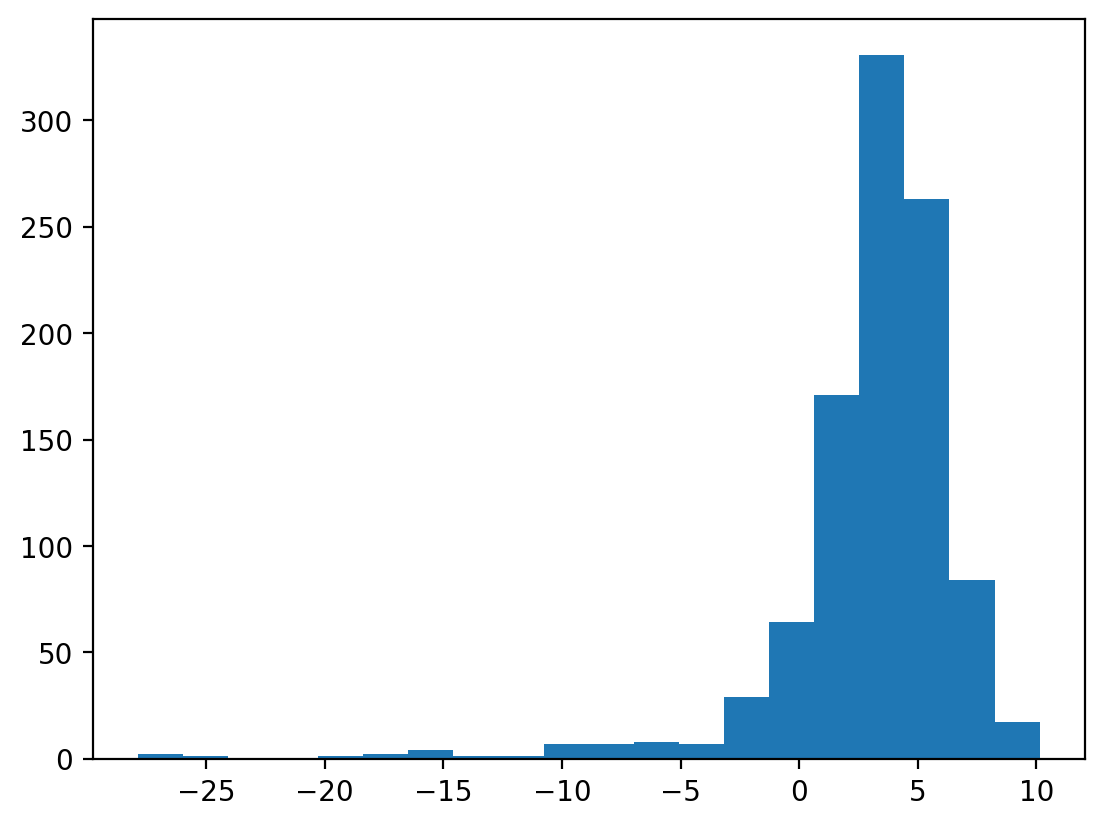

In [219]:
model_opt = opt[1]
sm_data = sample_langevin_dynamics(model_opt, 1000).detach()
plt.hist(sm_data.squeeze(1), bins=20)

## Noise Conditional Score Networks

In [232]:
alpha = .5
L = 3
sigma = [alpha**l for l in range(L)] 
print(sigma)

[1.0, 0.5, 0.25]


In [246]:
def ncsn_loss(model, X):
    loss = None
    for x in X:
        for i in range(L):
            x_tilde = torch.distributions.Normal(x, sigma[i]).sample()
            # print(x_tilde.shape)
            x_tilde.requires_grad_(True)
            s = model(torch.cat((x, torch.Tensor([sigma[i]]))))
            s.requires_grad_(True)
            # print(s, x, x_tilde)
            l = sigma[i]**2 * (s + (x_tilde-x)/sigma[i]**2)**2
            loss = l if loss is None else loss + l
    return loss 

In [247]:
class aNCSN(nn.Module):
    def __init__(self):
        super(aNCSN, self).__init__()
        hidden_layers = [nn.Linear(10, 10), nn.ReLU()]*1
        self.net = nn.Sequential(
            nn.Linear(2, 10),
            *hidden_layers,
            nn.Linear(10, 1),
        )

    def forward(self, x):
        return self.net(x)

model = aNCSN()
optimizer = optim.Adam(model.parameters(), lr=.001)

num_epochs = 50

opt = (float('inf'), None)
for epoch in range(num_epochs):
    avg_loss = 0
    for X in train_dataloader:
        for i in range(L):
            loss = ncsn_loss(model, torch.cat((X, torch.full((len(X), 1), sigma[i]))))
            # print(loss)
            avg_loss += loss[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss /= len(train_dataloader)/L
    opt = min(opt, (avg_loss, model))
model_opt = opt[1]

In [248]:
num_steps = 200
eps = .01

In [249]:
def sample_ald(model, n):
    # print(model)
    X = torch.randn(n, 1)
    for i in range(L):
        alpha = eps * (sigma[i]/sigma[L-1])**2
        print(alpha)
        for t in range(num_steps):
            # print(X[:10], torch.full((n, 1), sigma[i])[:10], torch.cat((X, torch.full((n, 1), sigma[i])), 1))
            # print(torch.cat((X, torch.full((n, 1), sigma[i])), 1))
            s = model(torch.cat((X, torch.full((n, 1), sigma[i])), 1))
            X += alpha/2 * s + sqrt(alpha) * torch.distributions.Normal(0, sigma[i]).sample([n, 1])
    return X

0.16
0.04
0.01


(array([  2.,   2.,   2.,  15.,  23.,  55., 106., 124., 119., 171., 135.,
        101.,  71.,  39.,  20.,  11.,   2.,   0.,   1.,   1.]),
 array([-21.64036751, -19.25545692, -16.87054825, -14.48563766,
        -12.10072708,  -9.71581745,  -7.33090734,  -4.94599724,
         -2.56108737,  -0.17617741,   2.2087326 ,   4.59364271,
          6.97855282,   9.36346245,  11.74837303,  14.13328266,
         16.51819229,  18.90310287,  21.28801346,  23.67292213,
         26.05783272]),
 <BarContainer object of 20 artists>)

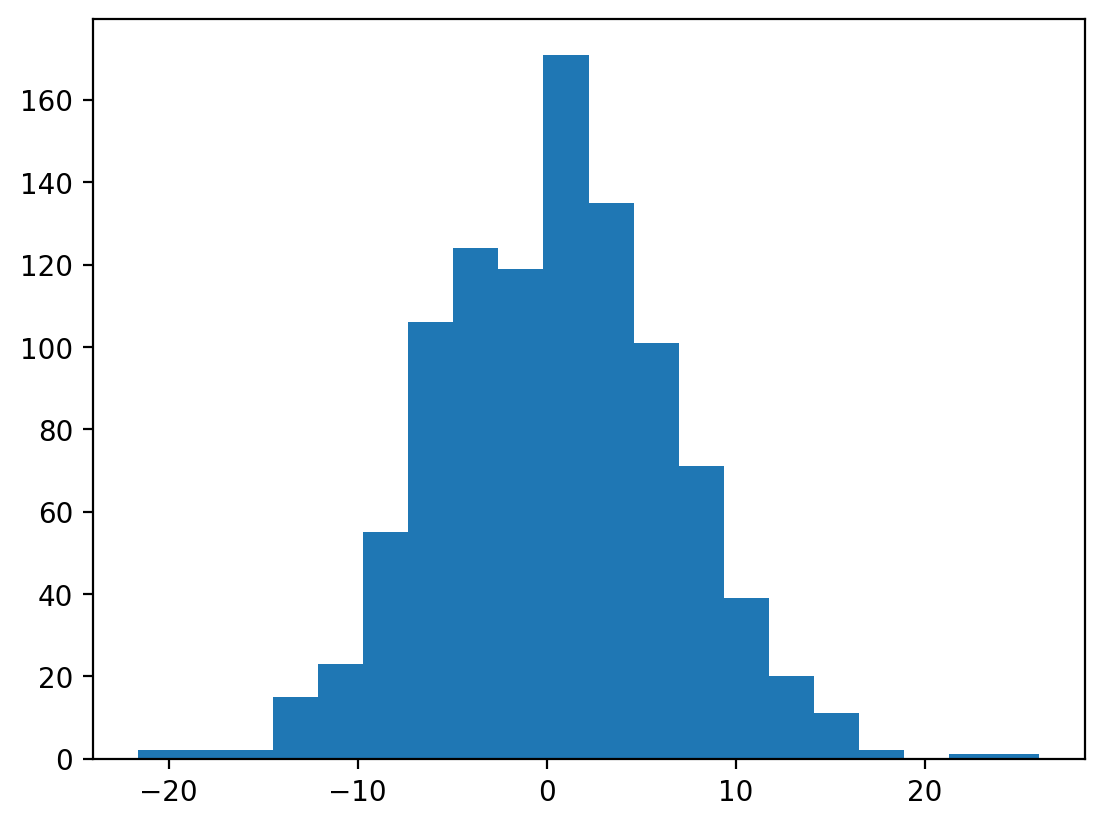

In [250]:
sm_data = sample_ald(model_opt, 1000).detach()
# print(sm_data)
plt.hist(sm_data.squeeze(1), bins=20)